## 0. Imports

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 12.9 MB/s eta 0:00:00


In [ ]:
!pip install feature_engine


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.4/319.4 KB 2.1 MB/s eta 0:00:00


In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 8.7 MB/s eta 0:00:00


In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install torch-summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score, fbeta_score, make_scorer, classification_report, confusion_matrix, accuracy_score
import statsmodels.api as sm
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from feature_engine.creation import CyclicalFeatures
from catboost import CatBoostRegressor, CatBoostClassifier
import random
import optuna

In [ ]:
import torch
import torchvision
from torchvision import models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from torch import nn
from torch.nn import functional as F
from torch.utils.data import random_split, DataLoader
from torchvision import transforms, datasets
import tqdm
import copy
from torchvision.io import read_image
import os
from torchmetrics import Accuracy
from torchsummary import summary

In [ ]:
SEED = 22
sns.set(rc={"figure.figsize":(12, 8)})


I'll try to fix seed to get simmilar results every time.

In [ ]:
def seed_everything(seed):
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(12)

## 1. Data Loading

In [ ]:
PATH = '/content/drive/MyDrive/datasets/hotdog__not_hotdog'
train_dir = PATH + '/train'
test_dir = PATH + '/test'

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize((200, 200)),
                                 ])

In [ ]:
train = datasets.ImageFolder(PATH + '/train', transform=transform)
test = datasets.ImageFolder(PATH + '/test', transform=transform)

In [ ]:
generator = torch.Generator().manual_seed(12)
val_subset, test_subset = random_split(test, [0.5, 0.5], generator=generator)

In [ ]:
trainloader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True)

Feature batch shape: torch.Size([32, 3, 200, 200])
Labels batch shape: torch.Size([32])


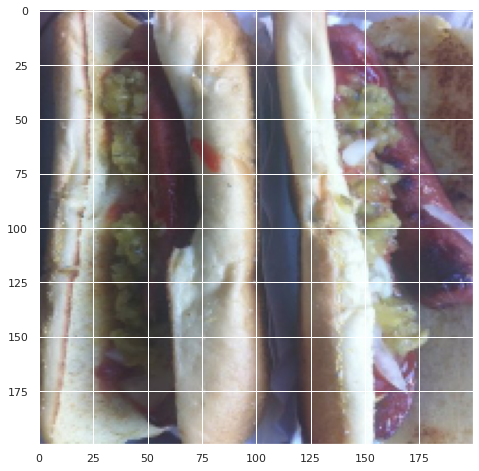

Label: 0


In [ ]:
train_features, train_labels = next(iter(trainloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
#img = train_features[0].squeeze().squeeze()
img = train_features[23].numpy().transpose((1, 2, 0))
label = train_labels[23]
plt.imshow(img)
plt.show()
print(f"Label: {label}")

Loading of data was succesful.

For training datset, I'll use different augmentations: RandomRotation and ColorJitter - those will bring more diversity into position and colours of the dataset.


As the pictures are quite big, in order to make task computationally easier, I'll resize pictures into 200*200.

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize((200, 200)),
                                transforms.ColorJitter(brightness=.5, hue=.1),
                                #transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5.)),
                                transforms.RandomRotation(degrees=(0, 180))
                                 ])

In [ ]:
train.transform = transform

In [ ]:
trainloader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True)

Feature batch shape: torch.Size([32, 3, 200, 200])
Labels batch shape: torch.Size([32])


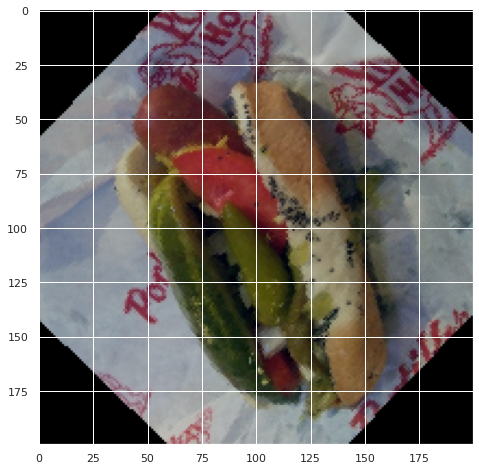

Label: 0


In [ ]:
train_features, train_labels = next(iter(trainloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
#img = train_features[0].squeeze().squeeze()
img = train_features[12].numpy().transpose((1, 2, 0))
label = train_labels[12]
plt.imshow(img)
plt.show()
print(f"Label: {label}")

It is seen that the augmentations were applied.

## 2. Functions initialization

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()

In [ ]:
accuracy = Accuracy(task='binary')

For training process I'll use validation dataset to  calculate accuracy and save best weights. I won't calculate it on whole dataset as it is quite a lengthy process, but instead will use 100 random samples.

In [ ]:
def show_results(history_tr, history_tst, metric='Accuracy'):
  print(f'Biggest val {metric} = {max(history_tst)}')
  print(f'Smallest val {metric} = {min(history_tst)}')
  plt.plot(history_tst)
  plt.plot(history_tr)
  plt.legend(labels=[f'Val {metric}', f'Train {metric}'])
  plt.title(f'{metric} on epochs')
  plt.show()

def validate_epoch(model, dataset, batch_size):
  subset, _ = random_split(dataset, [100, len(dataset) - 100])
  val_dataloader = DataLoader(subset, batch_size=batch_size, shuffle=True)
  num_batches = 0
  loss = 0
  accuracy_score = 0
  for X, y in val_dataloader:
    y = y.float()
    pred = model(X)
    loss += loss_fn(pred, y).item()
    accuracy_score += accuracy(pred, y).item()
    num_batches += 1
  accuracy_score = accuracy_score / num_batches
  loss = loss/num_batches
  return loss, accuracy_score


def early_stop(epoch, history):
  if epoch > 3 and abs(history[-3] - history[-2]) < 0.01 and abs(history[-2] - history[-1]) < 0.01:
    print('')
    print('Early stop: plato found')
    return 1
  elif epoch > 15 and (np.max(history[-8: -4]) > np.max(history[-4:])):
    print('')
    print('Early stop: error increasing')
    return 1
  return 0

def train_cv(model, n_epochs=50, batch_size=32, disable_bar=False, check_early_stop=True):
  # Hold the best model
  best_loss = np.inf   # init to infinity
  best_weights = None
  history_val_loss, history_tr_loss = [], []
  history_val_acc, history_tr_acc  = [], []
  train_dataloader = DataLoader(train, batch_size=batch_size, shuffle=True)
  for epoch in range(n_epochs):
      model.train()

      loop = tqdm.tqdm(train_dataloader, unit="batch", mininterval=0, disable=disable_bar)
      loop.set_description(f"Epoch {epoch}")

      for X_batch, y_batch in loop :
          y_pred = model(X_batch)
          y_batch = y_batch.float()
          loss = loss_fn(y_pred, y_batch)
          # backward pass
          optimizer = model.get_optimizer()
          optimizer.zero_grad()
          loss.backward()
          # update weights
          optimizer.step()
          # print progress
          loop.set_postfix(cross_entropy=loss.item())
      # evaluate accuracy at end of each epoch
      model.eval()
      loss_val, acc_val = validate_epoch(model, val_subset, batch_size)
      history_val_loss.append(loss_val)
      history_val_acc.append(acc_val)
      loss_tr, acc_tr = validate_epoch(model, train, batch_size)
      history_tr_loss.append(loss_tr)
      history_tr_acc.append(acc_tr)
      print(f'Epoch ended, accuracy val score = {acc_val}')
      if loss_val < best_loss:
          best_loss = loss_val
          best_weights = copy.deepcopy(model.state_dict())
      if check_early_stop:
        if early_stop(epoch, history_val_acc):
          break
  return history_val_loss, history_tr_loss, history_val_acc, history_tr_acc, best_weights


In [ ]:
def evaluate_model(model, dataset, batch_size=25):
  val_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
  num_batches = 0
  accuracy_score = 0
  for X, y in val_dataloader:
    y = y.float()
    pred = model(X)
    accuracy_score += accuracy(pred, y).item()
    num_batches += 1
  accuracy_score = accuracy_score / num_batches
  print(f'Accuracy score =  = {accuracy_score}')
  return accuracy

## 3. Basic model

In [ ]:
class BasicCV(nn.Module):
  def __init__(self, input=3, learning_rate=0.001):
    super().__init__()
    self.conv1 = nn.Conv2d(input, 3, 3) # 198
    self.pool = nn.MaxPool2d(4) # (198 - 4) // 4 + 1 = 49
    self.conv2 = nn.Conv2d(3, 3, 3) # pool(47) = 11
    self.fc1 = nn.Linear(11 * 11 * 3, 64)
    self.fc2 = nn.Linear(64, 1)
    self.m1 = nn.BatchNorm1d(11 * 11 * 3)
    self.learning_rate = learning_rate

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool(x)
    x = F.relu(self.conv2(x))
    x = self.pool(x)
    #x = self.pool(F.relu(self.conv2(x)))
    x = torch.flatten(x, 1) # flatten all dimensions except batch
    x = F.relu(self.fc1(x))
    x = F.sigmoid(self.fc2(x)).squeeze()
    #print(x)
    return x

  def get_optimizer(self):
      optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
      return optimizer

In [ ]:
basic_cv = BasicCV()
summary(basic_cv)

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            84
├─MaxPool2d: 1-2                         --
├─Conv2d: 1-3                            84
├─Linear: 1-4                            23,296
├─Linear: 1-5                            65
├─BatchNorm1d: 1-6                       726
Total params: 24,255
Trainable params: 24,255
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            84
├─MaxPool2d: 1-2                         --
├─Conv2d: 1-3                            84
├─Linear: 1-4                            23,296
├─Linear: 1-5                            65
├─BatchNorm1d: 1-6                       726
Total params: 24,255
Trainable params: 24,255
Non-trainable params: 0

In [ ]:
history_val_loss, history_tr_loss, history_val_acc, history_tr_acc, best_weights = train_cv(basic_cv, 50, 32, check_early_stop=True)

Epoch 0:   0%|          | 0/16 [00:00<?, ?batch/s]/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Epoch 0: 100%|██████████| 16/16 [00:12<00:00,  1.25batch/s, cross_entropy=23.1]


Epoch ended, accuracy val score = 0.5546875


Epoch 1: 100%|██████████| 16/16 [00:15<00:00,  1.01batch/s, cross_entropy=28.9]


Epoch ended, accuracy val score = 0.5234375


Epoch 2: 100%|██████████| 16/16 [00:13<00:00,  1.17batch/s, cross_entropy=17.3]


Epoch ended, accuracy val score = 0.5625


Epoch 3: 100%|██████████| 16/16 [00:13<00:00,  1.16batch/s, cross_entropy=17.2]


Epoch ended, accuracy val score = 0.5390625


Epoch 4: 100%|██████████| 16/16 [00:13<00:00,  1.16batch/s, cross_entropy=31.9]


Epoch ended, accuracy val score = 0.4765625


Epoch 5: 100%|██████████| 16/16 [00:14<00:00,  1.11batch/s, cross_entropy=22.8]


Epoch ended, accuracy val score = 0.4375


Epoch 6: 100%|██████████| 16/16 [00:13<00:00,  1.18batch/s, cross_entropy=25.8]


Epoch ended, accuracy val score = 0.4921875


Epoch 7: 100%|██████████| 16/16 [00:24<00:00,  1.54s/batch, cross_entropy=28.7]


Epoch ended, accuracy val score = 0.5859375


Epoch 8: 100%|██████████| 16/16 [00:15<00:00,  1.06batch/s, cross_entropy=25.9]


Epoch ended, accuracy val score = 0.4140625


Epoch 9: 100%|██████████| 16/16 [00:20<00:00,  1.30s/batch, cross_entropy=17.1]


Epoch ended, accuracy val score = 0.65625


Epoch 10: 100%|██████████| 16/16 [00:15<00:00,  1.03batch/s, cross_entropy=23]


Epoch ended, accuracy val score = 0.46875


Epoch 11: 100%|██████████| 16/16 [00:16<00:00,  1.05s/batch, cross_entropy=25.8]


Epoch ended, accuracy val score = 0.515625


Epoch 12: 100%|██████████| 16/16 [00:17<00:00,  1.11s/batch, cross_entropy=28.9]


Epoch ended, accuracy val score = 0.5078125


Epoch 13: 100%|██████████| 16/16 [00:13<00:00,  1.17batch/s, cross_entropy=23.4]


Epoch ended, accuracy val score = 0.6796875


Epoch 14: 100%|██████████| 16/16 [00:14<00:00,  1.07batch/s, cross_entropy=25.7]


Epoch ended, accuracy val score = 0.625


Epoch 15: 100%|██████████| 16/16 [00:13<00:00,  1.16batch/s, cross_entropy=31.4]


Epoch ended, accuracy val score = 0.578125


Epoch 16: 100%|██████████| 16/16 [00:13<00:00,  1.17batch/s, cross_entropy=33.9]


Epoch ended, accuracy val score = 0.5390625


Epoch 17: 100%|██████████| 16/16 [00:19<00:00,  1.24s/batch, cross_entropy=22.6]


Epoch ended, accuracy val score = 0.625

Early stop: error increasing


Biggest val Entropy = 48.03374242782593
Smallest val Entropy = 37.21874761581421


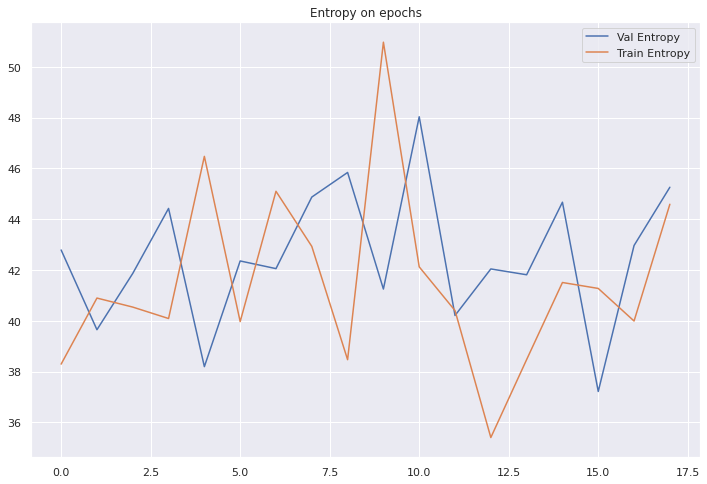

In [ ]:
basic_cv.load_state_dict(best_weights)
show_results(history_tr_loss, history_val_loss, metric='Entropy')

Biggest val Accuracy = 0.6796875
Smallest val Accuracy = 0.4140625


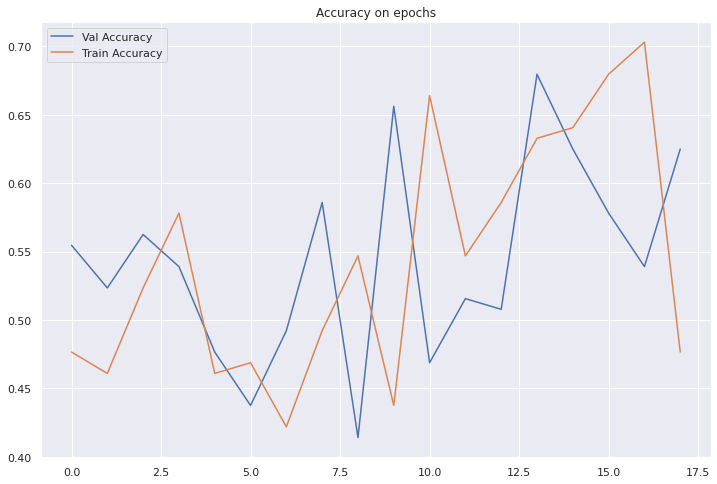

In [ ]:
show_results(history_tr_acc, history_val_acc, metric='Accuracy')

In [ ]:
evaluate_model(basic_cv, test_subset)

Accuracy score =  = 0.5079999953508377


BinaryAccuracy()

Based on training plots, I think the model is underfit - both loss and accuracy plots are very cheotic and the model did't preform much better then a dummy clasifier woud. I'll try increasing number of convolutions.

## 4. More complicated models

In [ ]:
class BasicPlusCV(nn.Module):
  def __init__(self, input=3, learning_rate=0.001):
    super().__init__()
    self.conv1 = nn.Conv2d(input, 32, 3, padding=1)
    self.pool = nn.MaxPool2d(2) # 100
    self.conv2 = nn.Conv2d(32, 64, 3, padding=1) # pool(x) = 50
    self.conv3 = nn.Conv2d(64, 128, 3, padding=1) # pool(x) = 25
    self.conv4 = nn.Conv2d(128, 128, 3, padding=1) # pool(x) = 12
    self.fc1 = nn.Linear(12 * 12 * 128, 16)
    self.fc2 = nn.Linear(16, 1)
    self.m1 = nn.BatchNorm1d(12 * 12 * 128)
    self.learning_rate = learning_rate

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool(x)
    x = F.relu(self.conv2(x))
    x = self.pool(x)
    x = F.relu(self.conv3(x))
    x = self.pool(x)
    x = F.relu(self.conv4(x))
    x = self.pool(x)
    #x = self.pool(F.relu(self.conv2(x)))
    x = torch.flatten(x, 1) # flatten all dimensions except batch
    x = self.m1(x)
    x = F.relu(self.fc1(x))
    x = F.sigmoid(self.fc2(x)).squeeze()
    return x

  def get_optimizer(self):
      optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
      return optimizer

In [ ]:
cv_plus = BasicPlusCV()
summary(cv_plus)

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            896
├─MaxPool2d: 1-2                         --
├─Conv2d: 1-3                            18,496
├─Conv2d: 1-4                            73,856
├─Conv2d: 1-5                            147,584
├─Linear: 1-6                            294,928
├─Linear: 1-7                            17
├─BatchNorm1d: 1-8                       36,864
Total params: 572,641
Trainable params: 572,641
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            896
├─MaxPool2d: 1-2                         --
├─Conv2d: 1-3                            18,496
├─Conv2d: 1-4                            73,856
├─Conv2d: 1-5                            147,584
├─Linear: 1-6                            294,928
├─Linear: 1-7                            17
├─BatchNorm1d: 1-8                       36,864
Total params: 572,641
Trainable params: 572,641
Non-trainable params: 0

In [ ]:
history_val_loss, history_tr_loss, history_val_acc, history_tr_acc, best_weights = train_cv(cv_plus, 50, 25, check_early_stop=True)

Epoch 0:   0%|          | 0/20 [00:00<?, ?batch/s]/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Epoch 0: 100%|██████████| 20/20 [00:56<00:00,  2.84s/batch, cross_entropy=39]


Epoch ended, accuracy val score = 0.46000000089406967


Epoch 1: 100%|██████████| 20/20 [00:51<00:00,  2.60s/batch, cross_entropy=43.2]


Epoch ended, accuracy val score = 0.6200000047683716


Epoch 2: 100%|██████████| 20/20 [00:53<00:00,  2.66s/batch, cross_entropy=27.8]


Epoch ended, accuracy val score = 0.5900000035762787


Epoch 3: 100%|██████████| 20/20 [00:51<00:00,  2.59s/batch, cross_entropy=33]


Epoch ended, accuracy val score = 0.5700000077486038


Epoch 4: 100%|██████████| 20/20 [00:52<00:00,  2.61s/batch, cross_entropy=40.6]


Epoch ended, accuracy val score = 0.5199999883770943


Epoch 5: 100%|██████████| 20/20 [00:52<00:00,  2.62s/batch, cross_entropy=38.8]


Epoch ended, accuracy val score = 0.6099999994039536


Epoch 6: 100%|██████████| 20/20 [00:52<00:00,  2.64s/batch, cross_entropy=37.3]


Epoch ended, accuracy val score = 0.47999999672174454


Epoch 7: 100%|██████████| 20/20 [00:53<00:00,  2.68s/batch, cross_entropy=28.3]


Epoch ended, accuracy val score = 0.5599999949336052


Epoch 8: 100%|██████████| 20/20 [00:53<00:00,  2.66s/batch, cross_entropy=41.8]


Epoch ended, accuracy val score = 0.7199999988079071


Epoch 9: 100%|██████████| 20/20 [00:52<00:00,  2.61s/batch, cross_entropy=18.8]


Epoch ended, accuracy val score = 0.5700000002980232


Epoch 10: 100%|██████████| 20/20 [00:51<00:00,  2.58s/batch, cross_entropy=28.6]


Epoch ended, accuracy val score = 0.6599999964237213


Epoch 11: 100%|██████████| 20/20 [00:54<00:00,  2.72s/batch, cross_entropy=28.3]


Epoch ended, accuracy val score = 0.5699999928474426


Epoch 12: 100%|██████████| 20/20 [00:51<00:00,  2.60s/batch, cross_entropy=32]


Epoch ended, accuracy val score = 0.6000000089406967


Epoch 13: 100%|██████████| 20/20 [00:52<00:00,  2.62s/batch, cross_entropy=28.5]


Epoch ended, accuracy val score = 0.6400000005960464


Epoch 14: 100%|██████████| 20/20 [00:52<00:00,  2.65s/batch, cross_entropy=21.6]


Epoch ended, accuracy val score = 0.5600000098347664


Epoch 15: 100%|██████████| 20/20 [00:45<00:00,  2.25s/batch, cross_entropy=28.4]


Epoch ended, accuracy val score = 0.6200000047683716


Epoch 16: 100%|██████████| 20/20 [00:52<00:00,  2.61s/batch, cross_entropy=19.1]


Epoch ended, accuracy val score = 0.5699999928474426


Epoch 17: 100%|██████████| 20/20 [00:52<00:00,  2.62s/batch, cross_entropy=33.4]


Epoch ended, accuracy val score = 0.6200000047683716


Epoch 18: 100%|██████████| 20/20 [00:52<00:00,  2.62s/batch, cross_entropy=28.3]


Epoch ended, accuracy val score = 0.6899999976158142


Epoch 19: 100%|██████████| 20/20 [00:51<00:00,  2.60s/batch, cross_entropy=34.2]


Epoch ended, accuracy val score = 0.6500000059604645


Epoch 20: 100%|██████████| 20/20 [00:53<00:00,  2.67s/batch, cross_entropy=23.9]


Epoch ended, accuracy val score = 0.5899999961256981


Epoch 21: 100%|██████████| 20/20 [00:50<00:00,  2.54s/batch, cross_entropy=24]


Epoch ended, accuracy val score = 0.6599999964237213

Early stop: error increasing


Biggest val Accuracy = 0.7199999988079071
Smallest val Accuracy = 0.46000000089406967


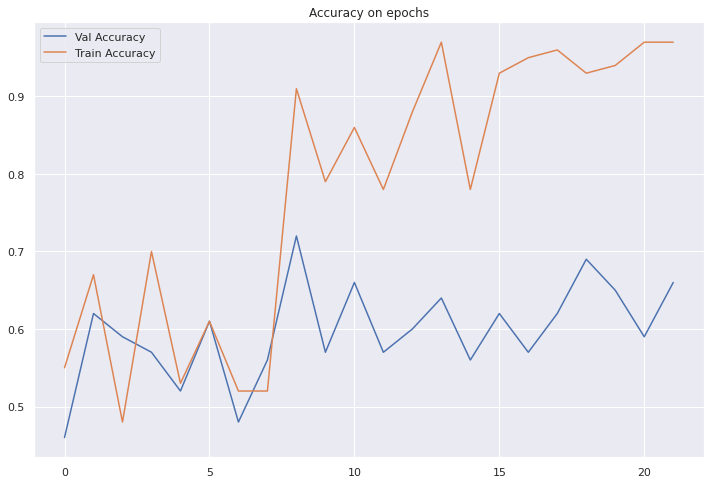

In [ ]:
show_results(history_tr_acc, history_val_acc, metric='Accuracy')

Biggest val Entropy = 45.62831687927246
Smallest val Entropy = 35.944591999053955


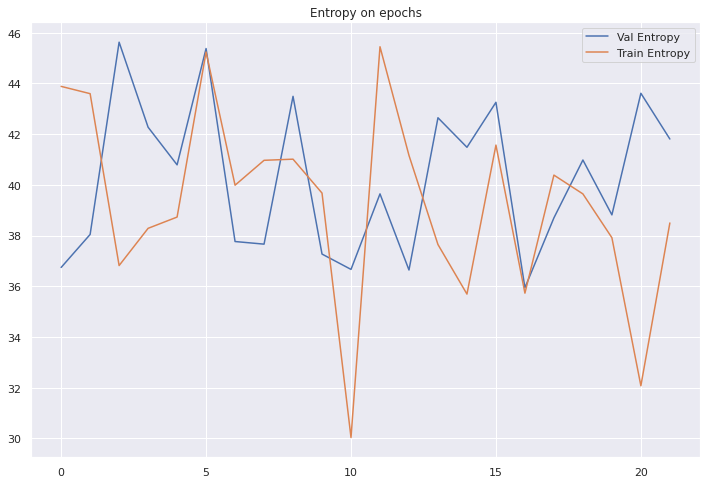

In [ ]:
cv_plus.load_state_dict(best_weights)
show_results(history_tr_loss, history_val_loss, metric='Entropy')

In [ ]:
evaluate_model(cv_plus, test_subset)

Accuracy score =  = 0.6159999996423722


BinaryAccuracy()

The accuracy on train dataset is very high while validation one is much smaller - the model is overfitting so I'll try adding dropouts and weight decay to optimizer. The entropy plot on the other hand is pretty random. I guess there is sense in finding optimal batch size and learning_rate to fix it.

In [ ]:
cv_plus16 = BasicPlusCV()
summary(cv_plus16)

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            896
├─MaxPool2d: 1-2                         --
├─Conv2d: 1-3                            18,496
├─Conv2d: 1-4                            73,856
├─Conv2d: 1-5                            147,584
├─Linear: 1-6                            294,928
├─Linear: 1-7                            17
├─BatchNorm1d: 1-8                       36,864
Total params: 572,641
Trainable params: 572,641
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            896
├─MaxPool2d: 1-2                         --
├─Conv2d: 1-3                            18,496
├─Conv2d: 1-4                            73,856
├─Conv2d: 1-5                            147,584
├─Linear: 1-6                            294,928
├─Linear: 1-7                            17
├─BatchNorm1d: 1-8                       36,864
Total params: 572,641
Trainable params: 572,641
Non-trainable params: 0

In [ ]:
history_val_loss, history_tr_loss, history_val_acc, history_tr_acc, best_weights = train_cv(cv_plus16, 50, 16, check_early_stop=True)

Epoch 0:   0%|          | 0/32 [00:00<?, ?batch/s]/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Epoch 0: 100%|██████████| 32/32 [00:58<00:00,  1.83s/batch, cross_entropy=1.16]


Epoch ended, accuracy val score = 0.625


Epoch 1: 100%|██████████| 32/32 [00:56<00:00,  1.75s/batch, cross_entropy=0.882]


Epoch ended, accuracy val score = 0.5714285714285714


Epoch 2: 100%|██████████| 32/32 [00:57<00:00,  1.80s/batch, cross_entropy=-]


Epoch ended, accuracy val score = 0.5267857142857143


Epoch 3: 100%|██████████| 32/32 [00:56<00:00,  1.75s/batch, cross_entropy=0.313]


Epoch ended, accuracy val score = 0.5892857142857143


Epoch 4: 100%|██████████| 32/32 [00:56<00:00,  1.76s/batch, cross_entropy=1.59]


Epoch ended, accuracy val score = 0.5625


Epoch 5: 100%|██████████| 32/32 [00:56<00:00,  1.77s/batch, cross_entropy=0.333]


Epoch ended, accuracy val score = 0.5803571428571429


Epoch 6: 100%|██████████| 32/32 [00:56<00:00,  1.76s/batch, cross_entropy=-]


Epoch ended, accuracy val score = 0.6607142857142857


Epoch 7: 100%|██████████| 32/32 [00:56<00:00,  1.75s/batch, cross_entropy=-]


Epoch ended, accuracy val score = 0.625


Epoch 8: 100%|██████████| 32/32 [00:55<00:00,  1.74s/batch, cross_entropy=0.314]


Epoch ended, accuracy val score = 0.6964285714285714


Epoch 9: 100%|██████████| 32/32 [00:53<00:00,  1.68s/batch, cross_entropy=-]


Epoch ended, accuracy val score = 0.625


Epoch 10: 100%|██████████| 32/32 [00:55<00:00,  1.74s/batch, cross_entropy=0.313]


Epoch ended, accuracy val score = 0.5446428571428571


Epoch 11: 100%|██████████| 32/32 [00:55<00:00,  1.74s/batch, cross_entropy=1.4]


Epoch ended, accuracy val score = 0.625


Epoch 12: 100%|██████████| 32/32 [01:11<00:00,  2.22s/batch, cross_entropy=1.61]


Epoch ended, accuracy val score = 0.6696428571428571


Epoch 13: 100%|██████████| 32/32 [00:53<00:00,  1.66s/batch, cross_entropy=0.552]


Epoch ended, accuracy val score = 0.7410714285714286


Epoch 14: 100%|██████████| 32/32 [00:55<00:00,  1.75s/batch, cross_entropy=0.313]


Epoch ended, accuracy val score = 0.5982142857142857


Epoch 15: 100%|██████████| 32/32 [00:54<00:00,  1.72s/batch, cross_entropy=1.39]


Epoch ended, accuracy val score = 0.6428571428571429


Epoch 16: 100%|██████████| 32/32 [00:56<00:00,  1.77s/batch, cross_entropy=-]


Epoch ended, accuracy val score = 0.5535714285714286

Early stop: error increasing


Biggest val Accuracy = 0.7410714285714286
Smallest val Accuracy = 0.5267857142857143


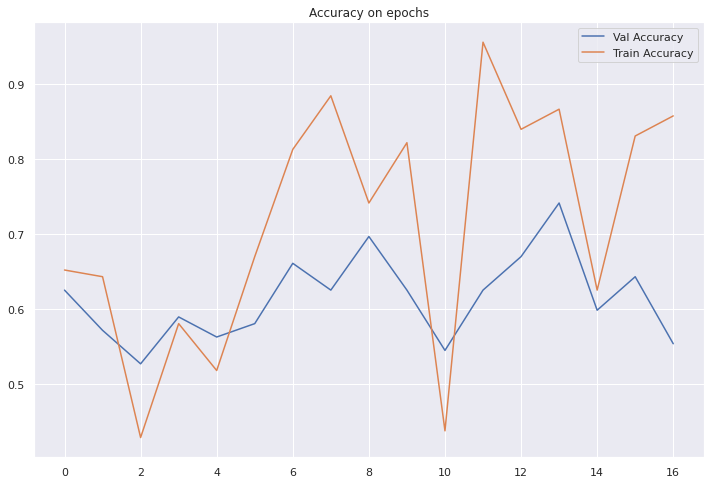

In [ ]:
show_results(history_tr_acc, history_val_acc, metric='Accuracy')

Biggest val Entropy = 21.793421660150802
Smallest val Entropy = 17.492394311087473


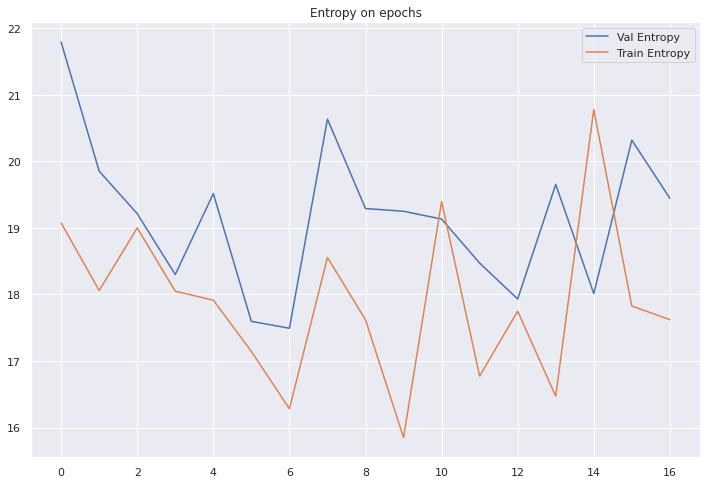

In [ ]:
cv_plus.load_state_dict(best_weights)
show_results(history_tr_loss, history_val_loss, metric='Entropy')

In [ ]:
evaluate_model(cv_plus, test_subset)

Accuracy score =  = 0.6040000021457672


BinaryAccuracy()

The result looks a bit more smooth, there is less overfitting and entropy is smaller. On the other hand, the entropy is still pretty random.

I'll try even less batch_size.

In [ ]:
cv_plus10 = BasicPlusCV()

In [ ]:
history_val_loss, history_tr_loss, history_val_acc, history_tr_acc, best_weights = train_cv(cv_plus10, 50, 10, check_early_stop=True)

Epoch 0:   0%|          | 0/50 [00:00<?, ?batch/s]/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Epoch 0: 100%|██████████| 50/50 [01:04<00:00,  1.30s/batch, cross_entropy=10.5]


Epoch ended, accuracy val score = 0.5500000149011612


Epoch 1: 100%|██████████| 50/50 [00:51<00:00,  1.03s/batch, cross_entropy=15.5]


Epoch ended, accuracy val score = 0.5399999976158142


Epoch 2: 100%|██████████| 50/50 [00:52<00:00,  1.05s/batch, cross_entropy=7.38]


Epoch ended, accuracy val score = 0.5700000077486038


Epoch 3: 100%|██████████| 50/50 [00:50<00:00,  1.01s/batch, cross_entropy=7.48]


Epoch ended, accuracy val score = 0.610000005364418


Epoch 4: 100%|██████████| 50/50 [00:51<00:00,  1.02s/batch, cross_entropy=7.46]


Epoch ended, accuracy val score = 0.5600000083446502


Epoch 5: 100%|██████████| 50/50 [00:51<00:00,  1.03s/batch, cross_entropy=9.75]


Epoch ended, accuracy val score = 0.5799999982118607


Epoch 6: 100%|██████████| 50/50 [00:51<00:00,  1.03s/batch, cross_entropy=10.5]


Epoch ended, accuracy val score = 0.5700000062584877


Epoch 7: 100%|██████████| 50/50 [00:50<00:00,  1.01s/batch, cross_entropy=9.17]


Epoch ended, accuracy val score = 0.6400000065565109


Epoch 8: 100%|██████████| 50/50 [00:49<00:00,  1.00batch/s, cross_entropy=5.73]


Epoch ended, accuracy val score = 0.44000000804662703


Epoch 9: 100%|██████████| 50/50 [00:51<00:00,  1.02s/batch, cross_entropy=1.6]


Epoch ended, accuracy val score = 0.5900000035762787


Epoch 10: 100%|██████████| 50/50 [00:51<00:00,  1.03s/batch, cross_entropy=9.79]


Epoch ended, accuracy val score = 0.6000000029802323


Epoch 11: 100%|██████████| 50/50 [00:51<00:00,  1.03s/batch, cross_entropy=9.47]


Epoch ended, accuracy val score = 0.5500000089406967


Epoch 12: 100%|██████████| 50/50 [00:50<00:00,  1.01s/batch, cross_entropy=5.29]


Epoch ended, accuracy val score = 0.5700000077486038


Epoch 13: 100%|██████████| 50/50 [00:50<00:00,  1.01s/batch, cross_entropy=5.44]


Epoch ended, accuracy val score = 0.5700000062584877


Epoch 14: 100%|██████████| 50/50 [00:51<00:00,  1.03s/batch, cross_entropy=8.05]


Epoch ended, accuracy val score = 0.5800000071525574


Epoch 15: 100%|██████████| 50/50 [00:51<00:00,  1.03s/batch, cross_entropy=14.8]


Epoch ended, accuracy val score = 0.5700000047683715


Epoch 16: 100%|██████████| 50/50 [00:51<00:00,  1.02s/batch, cross_entropy=7]


Epoch ended, accuracy val score = 0.5800000041723251

Early stop: error increasing


Biggest val Accuracy = 0.6400000065565109
Smallest val Accuracy = 0.44000000804662703


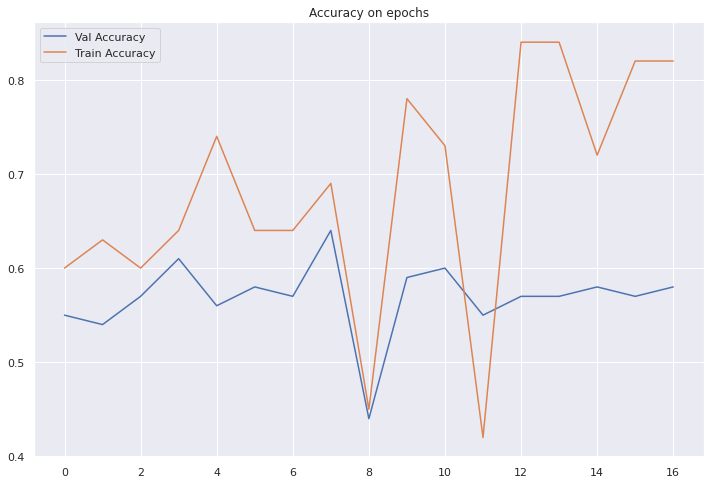

Biggest val Entropy = 13.861388397216796
Smallest val Entropy = 10.131335258483887


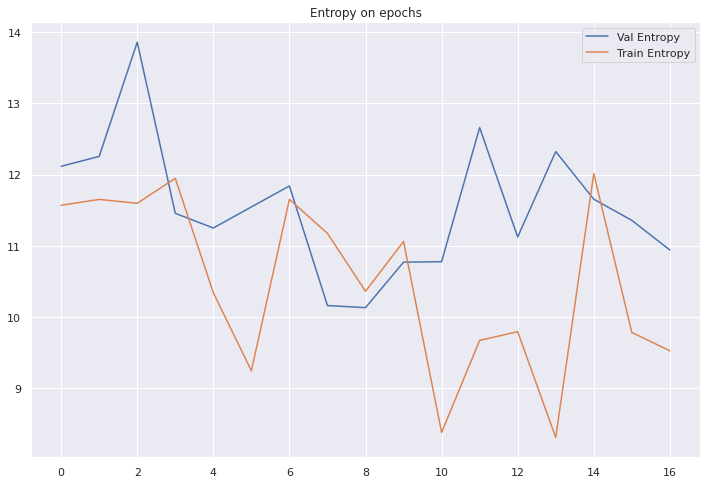

In [ ]:
cv_plus10.load_state_dict(best_weights)
show_results(history_tr_acc, history_val_acc, metric='Accuracy')
show_results(history_tr_loss, history_val_loss, metric='Entropy')

In [ ]:
evaluate_model(cv_plus10, test_subset);

/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy score =  = 0.4960000038146973


This batch size seems to be worse then the previous one as the accuracy dropped. All those models have a clear overfitting so I'll try to use weight decay and decrease number of channels.

In [ ]:
class PlusCVReg(nn.Module):
  def __init__(self, input=3, learning_rate=0.001, weight_decay=1e-5):
    super().__init__()
    self.conv1 = nn.Conv2d(input, 32, 3, padding=1)
    self.pool = nn.MaxPool2d(2) # 100
    self.conv2 = nn.Conv2d(32, 64, 3, padding=1) # pool(x) = 50
    self.conv3 = nn.Conv2d(64, 64, 3, padding=1) # pool(x) = 25
    self.conv4 = nn.Conv2d(64, 64, 3, padding=1) # pool(x) = 12
    self.fc1 = nn.Linear(12 * 12 * 64, 16)
    self.fc2 = nn.Linear(16, 1)
    self.m1 = nn.BatchNorm1d(12 * 12 * 64)
    self.learning_rate = learning_rate
    self.weight_decay = weight_decay

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool(x)
    x = F.relu(self.conv2(x))
    x = self.pool(x)
    x = F.relu(self.conv3(x))
    x = self.pool(x)
    x = F.relu(self.conv4(x))
    x = self.pool(x)
    #x = self.pool(F.relu(self.conv2(x)))
    x = torch.flatten(x, 1) # flatten all dimensions except batch
    x = self.m1(x)
    x = F.relu(self.fc1(x))
    x = F.sigmoid(self.fc2(x)).squeeze()
    return x

  def get_optimizer(self):
      optimizer = torch.optim.Adam(self.parameters(),
                                   lr=self.learning_rate,
                                   weight_decay=self.weight_decay)
      return optimizer

In [ ]:
smaller_model = PlusCVReg()
summary(smaller_model)

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            896
├─MaxPool2d: 1-2                         --
├─Conv2d: 1-3                            18,496
├─Conv2d: 1-4                            36,928
├─Conv2d: 1-5                            36,928
├─Linear: 1-6                            147,472
├─Linear: 1-7                            17
├─BatchNorm1d: 1-8                       18,432
Total params: 259,169
Trainable params: 259,169
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            896
├─MaxPool2d: 1-2                         --
├─Conv2d: 1-3                            18,496
├─Conv2d: 1-4                            36,928
├─Conv2d: 1-5                            36,928
├─Linear: 1-6                            147,472
├─Linear: 1-7                            17
├─BatchNorm1d: 1-8                       18,432
Total params: 259,169
Trainable params: 259,169
Non-trainable params: 0

In [ ]:
history_val_loss, history_tr_loss, history_val_acc, history_tr_acc, best_weights = train_cv(smaller_model, 50, 16, check_early_stop=True)

Epoch 0:   0%|          | 0/32 [00:00<?, ?batch/s]/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Epoch 0: 100%|██████████| 32/32 [00:53<00:00,  1.68s/batch, cross_entropy=1.42]


Epoch ended, accuracy val score = 0.44642857142857145


Epoch 1: 100%|██████████| 32/32 [00:47<00:00,  1.47s/batch, cross_entropy=-]


Epoch ended, accuracy val score = 0.5892857142857143


Epoch 2: 100%|██████████| 32/32 [00:40<00:00,  1.28s/batch, cross_entropy=-]


Epoch ended, accuracy val score = 0.44642857142857145


Epoch 3: 100%|██████████| 32/32 [00:47<00:00,  1.48s/batch, cross_entropy=0.466]


Epoch ended, accuracy val score = 0.6428571428571429


Epoch 4: 100%|██████████| 32/32 [00:46<00:00,  1.44s/batch, cross_entropy=1.27]


Epoch ended, accuracy val score = 0.5178571428571429


Epoch 5: 100%|██████████| 32/32 [00:45<00:00,  1.43s/batch, cross_entropy=1.54]


Epoch ended, accuracy val score = 0.48214285714285715


Epoch 6: 100%|██████████| 32/32 [00:46<00:00,  1.45s/batch, cross_entropy=0.405]


Epoch ended, accuracy val score = 0.5089285714285714


Epoch 7: 100%|██████████| 32/32 [00:45<00:00,  1.41s/batch, cross_entropy=1.46]


Epoch ended, accuracy val score = 0.6160714285714286


Epoch 8: 100%|██████████| 32/32 [00:46<00:00,  1.46s/batch, cross_entropy=0.325]


Epoch ended, accuracy val score = 0.6607142857142857


Epoch 9: 100%|██████████| 32/32 [00:45<00:00,  1.43s/batch, cross_entropy=-]


Epoch ended, accuracy val score = 0.5446428571428571


Epoch 10: 100%|██████████| 32/32 [00:46<00:00,  1.45s/batch, cross_entropy=0.484]


Epoch ended, accuracy val score = 0.6785714285714286


Epoch 11: 100%|██████████| 32/32 [00:47<00:00,  1.49s/batch, cross_entropy=-]


Epoch ended, accuracy val score = 0.6071428571428571


Epoch 12: 100%|██████████| 32/32 [00:45<00:00,  1.41s/batch, cross_entropy=0.315]


Epoch ended, accuracy val score = 0.5803571428571429


Epoch 13: 100%|██████████| 32/32 [00:45<00:00,  1.41s/batch, cross_entropy=0.396]


Epoch ended, accuracy val score = 0.5446428571428571


Epoch 14: 100%|██████████| 32/32 [00:46<00:00,  1.44s/batch, cross_entropy=1.49]


Epoch ended, accuracy val score = 0.5803571428571429


Epoch 15: 100%|██████████| 32/32 [00:45<00:00,  1.43s/batch, cross_entropy=0.326]


Epoch ended, accuracy val score = 0.5982142857142857


Epoch 16: 100%|██████████| 32/32 [00:45<00:00,  1.41s/batch, cross_entropy=1.39]


Epoch ended, accuracy val score = 0.5446428571428571

Early stop: error increasing


Biggest val Accuracy = 0.6785714285714286
Smallest val Accuracy = 0.44642857142857145


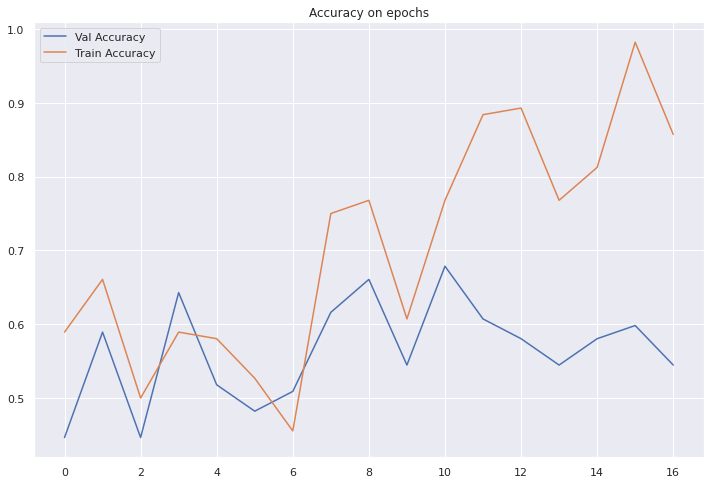

Biggest val Entropy = 22.336836133684432
Smallest val Entropy = 16.56010048730033


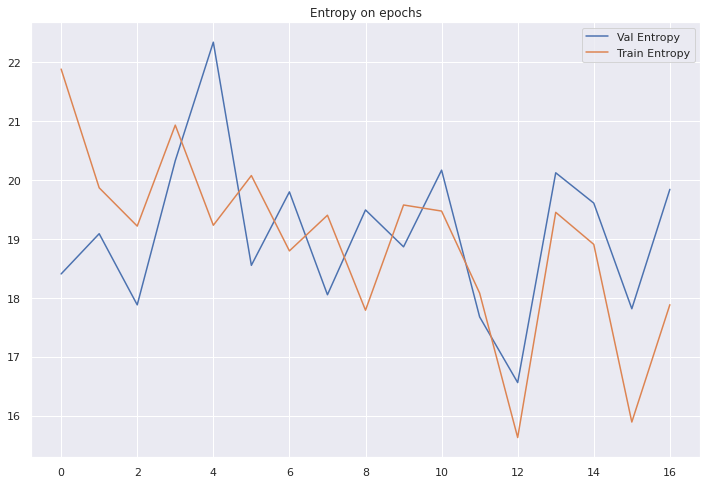

In [ ]:
smaller_model.load_state_dict(best_weights)
show_results(history_tr_acc, history_val_acc, metric='Accuracy')
show_results(history_tr_loss, history_val_loss, metric='Entropy')

In [ ]:
evaluate_model(smaller_model, test_subset);

/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy score =  = 0.6079999953508377


I've made the model more reguralized but it is still overfitting. I'll dropout.

In [ ]:
class PlusCVRegDrop(nn.Module):
  def __init__(self, input=3, learning_rate=0.001, weight_decay=1e-3, p1=0.2):
    super().__init__()
    self.conv1 = nn.Conv2d(input, 32, 3, padding=1)
    self.pool = nn.MaxPool2d(2) # 100
    self.conv2 = nn.Conv2d(32, 64, 3, padding=1) # pool(x) = 50
    self.conv3 = nn.Conv2d(64, 64, 3, padding=1) # pool(x) = 25
    self.conv4 = nn.Conv2d(64, 64, 3, padding=1) # pool(x) = 12
    self.fc1 = nn.Linear(12 * 12 * 64, 16)
    self.fc2 = nn.Linear(16, 1)
    self.m1 = nn.BatchNorm2d(32)
    self.m2 = nn.BatchNorm2d(64)
    self.m3 = nn.BatchNorm2d(64)
    self.m4 = nn.BatchNorm1d(12 * 12 * 64)
    self.d1 = nn.Dropout(p1)
    self.learning_rate = learning_rate
    self.weight_decay = weight_decay

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.m1(self.pool(x))
    x = F.relu(self.m2(self.conv2(x)))
    x = self.pool(x)
    x = F.relu(self.m3(self.conv3(x)))
    x = self.pool(x)
    x = F.relu(self.conv4(x))
    x = self.pool(x)
    x = self.d1(x)
    #x = self.pool(F.relu(self.conv2(x)))
    x = torch.flatten(x, 1) # flatten all dimensions except batch
    x = self.m4(x)
    x = F.relu(self.fc1(x))
    x = F.sigmoid(self.fc2(x)).squeeze()
    return x

  def get_optimizer(self):
      optimizer = torch.optim.Adam(self.parameters(),
                                   lr=self.learning_rate,
                                   weight_decay=self.weight_decay)
      return optimizer

In [ ]:
dropout_model = PlusCVRegDrop()
summary(dropout_model)

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            896
├─MaxPool2d: 1-2                         --
├─Conv2d: 1-3                            18,496
├─Conv2d: 1-4                            36,928
├─Conv2d: 1-5                            36,928
├─Linear: 1-6                            147,472
├─Linear: 1-7                            17
├─BatchNorm2d: 1-8                       64
├─BatchNorm2d: 1-9                       128
├─BatchNorm2d: 1-10                      128
├─BatchNorm1d: 1-11                      18,432
├─Dropout: 1-12                          --
Total params: 259,489
Trainable params: 259,489
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            896
├─MaxPool2d: 1-2                         --
├─Conv2d: 1-3                            18,496
├─Conv2d: 1-4                            36,928
├─Conv2d: 1-5                            36,928
├─Linear: 1-6                            147,472
├─Linear: 1-7                            17
├─BatchNorm2d: 1-8                       64
├─BatchNorm2d: 1-9                       128
├─BatchNorm2d: 1-10                      128
├─BatchNorm1d: 1-11                      18,432
├─Dropout: 1-12                          --
Total params: 259,489
Trainable params: 259,489
Non-trainable params: 0

In [ ]:
history_val_loss, history_tr_loss, history_val_acc, history_tr_acc, best_weights = train_cv(dropout_model, 50, 16, check_early_stop=True)

Epoch 0:   0%|          | 0/32 [00:00<?, ?batch/s]/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Epoch 0: 100%|██████████| 32/32 [00:46<00:00,  1.46s/batch, cross_entropy=-]


Epoch ended, accuracy val score = 0.4642857142857143


Epoch 1: 100%|██████████| 32/32 [00:45<00:00,  1.41s/batch, cross_entropy=1.54]


Epoch ended, accuracy val score = 0.49107142857142855


Epoch 2: 100%|██████████| 32/32 [00:46<00:00,  1.45s/batch, cross_entropy=0.355]


Epoch ended, accuracy val score = 0.5714285714285714


Epoch 3: 100%|██████████| 32/32 [00:43<00:00,  1.37s/batch, cross_entropy=-]


Epoch ended, accuracy val score = 0.5803571428571429


Epoch 4: 100%|██████████| 32/32 [00:46<00:00,  1.46s/batch, cross_entropy=0.375]


Epoch ended, accuracy val score = 0.7232142857142857


Epoch 5: 100%|██████████| 32/32 [00:47<00:00,  1.48s/batch, cross_entropy=0.455]


Epoch ended, accuracy val score = 0.6607142857142857


Epoch 6: 100%|██████████| 32/32 [00:38<00:00,  1.21s/batch, cross_entropy=0.372]


Epoch ended, accuracy val score = 0.6607142857142857


Epoch 7: 100%|██████████| 32/32 [00:47<00:00,  1.49s/batch, cross_entropy=-]


Epoch ended, accuracy val score = 0.5982142857142857


Epoch 8: 100%|██████████| 32/32 [00:46<00:00,  1.45s/batch, cross_entropy=1.55]


Epoch ended, accuracy val score = 0.5446428571428571


Epoch 9: 100%|██████████| 32/32 [00:46<00:00,  1.45s/batch, cross_entropy=-]


Epoch ended, accuracy val score = 0.5803571428571429


Epoch 10: 100%|██████████| 32/32 [00:47<00:00,  1.47s/batch, cross_entropy=-]


Epoch ended, accuracy val score = 0.5535714285714286


Epoch 11: 100%|██████████| 32/32 [00:55<00:00,  1.75s/batch, cross_entropy=1.6]


Epoch ended, accuracy val score = 0.5803571428571429


Epoch 12: 100%|██████████| 32/32 [00:46<00:00,  1.47s/batch, cross_entropy=1.45]


Epoch ended, accuracy val score = 0.5446428571428571


Epoch 13: 100%|██████████| 32/32 [00:45<00:00,  1.44s/batch, cross_entropy=0.313]


Epoch ended, accuracy val score = 0.7410714285714286


Epoch 14: 100%|██████████| 32/32 [00:47<00:00,  1.47s/batch, cross_entropy=1.52]


Epoch ended, accuracy val score = 0.7232142857142857


Epoch 15: 100%|██████████| 32/32 [00:48<00:00,  1.50s/batch, cross_entropy=0.314]


Epoch ended, accuracy val score = 0.5982142857142857


Epoch 16: 100%|██████████| 32/32 [00:46<00:00,  1.46s/batch, cross_entropy=0.929]


Epoch ended, accuracy val score = 0.6607142857142857


Epoch 17: 100%|██████████| 32/32 [00:45<00:00,  1.43s/batch, cross_entropy=-]


Epoch ended, accuracy val score = 0.6339285714285714

Early stop: error increasing


Biggest val Accuracy = 0.7410714285714286
Smallest val Accuracy = 0.4642857142857143


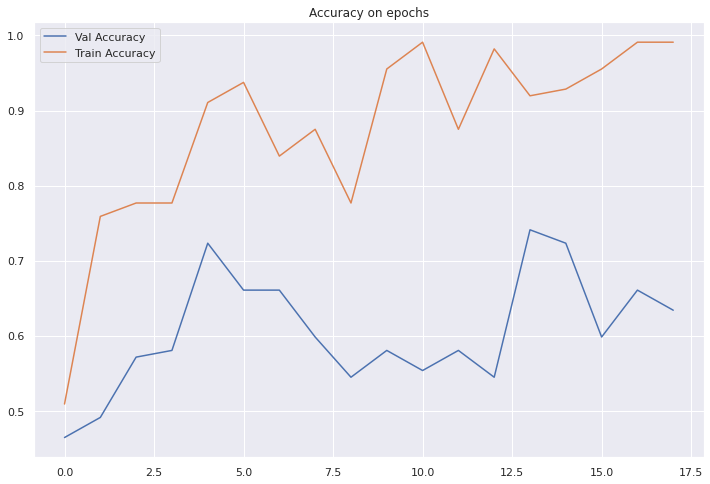

Biggest val Entropy = 21.373507227216447
Smallest val Entropy = 16.886781113488333


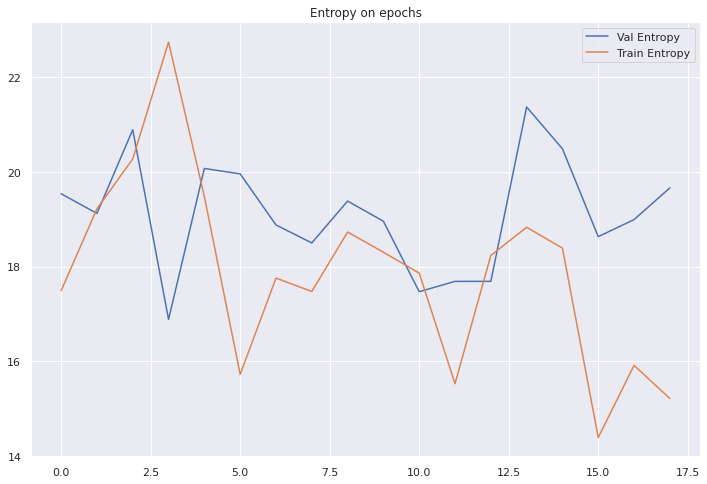

In [ ]:
dropout_model.load_state_dict(best_weights)
show_results(history_tr_acc, history_val_acc, metric='Accuracy')
show_results(history_tr_loss, history_val_loss, metric='Entropy')

In [ ]:
evaluate_model(dropout_model, test_subset);

Accuracy score =  = 0.6199999958276748


The test accuracy of this one is the best but probably increasing probability of dropout will imrove the results even more.

In [ ]:
dropout_model_05 = PlusCVRegDrop(weight_decay=0.01, p1=0.5)

In [ ]:
history_val_loss, history_tr_loss, history_val_acc, history_tr_acc, best_weights = train_cv(dropout_model_05, 50, 16, check_early_stop=True)

Epoch 0:   0%|          | 0/32 [00:00<?, ?batch/s]/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Epoch 0: 100%|██████████| 32/32 [01:02<00:00,  1.95s/batch, cross_entropy=-]


Epoch ended, accuracy val score = 0.5357142857142857


Epoch 1: 100%|██████████| 32/32 [00:49<00:00,  1.54s/batch, cross_entropy=0.908]


Epoch ended, accuracy val score = 0.6339285714285714


Epoch 2: 100%|██████████| 32/32 [01:14<00:00,  2.33s/batch, cross_entropy=1.07]


Epoch ended, accuracy val score = 0.6160714285714286


Epoch 3: 100%|██████████| 32/32 [01:11<00:00,  2.25s/batch, cross_entropy=-]


Epoch ended, accuracy val score = 0.5625


Epoch 4: 100%|██████████| 32/32 [01:04<00:00,  2.01s/batch, cross_entropy=0.677]


Epoch ended, accuracy val score = 0.5714285714285714


Epoch 5: 100%|██████████| 32/32 [01:02<00:00,  1.95s/batch, cross_entropy=-]


Epoch ended, accuracy val score = 0.625


Epoch 6: 100%|██████████| 32/32 [00:56<00:00,  1.77s/batch, cross_entropy=0.47]


Epoch ended, accuracy val score = 0.5892857142857143


Epoch 7: 100%|██████████| 32/32 [00:54<00:00,  1.71s/batch, cross_entropy=0.332]


Epoch ended, accuracy val score = 0.5


Epoch 8: 100%|██████████| 32/32 [00:58<00:00,  1.82s/batch, cross_entropy=-]


Epoch ended, accuracy val score = 0.7321428571428571


Epoch 9: 100%|██████████| 32/32 [01:02<00:00,  1.95s/batch, cross_entropy=0.371]


Epoch ended, accuracy val score = 0.6428571428571429


Epoch 10: 100%|██████████| 32/32 [00:47<00:00,  1.48s/batch, cross_entropy=-]


Epoch ended, accuracy val score = 0.75


Epoch 11: 100%|██████████| 32/32 [00:47<00:00,  1.48s/batch, cross_entropy=1.39]


Epoch ended, accuracy val score = 0.6785714285714286


Epoch 12: 100%|██████████| 32/32 [00:50<00:00,  1.57s/batch, cross_entropy=1.6]


Epoch ended, accuracy val score = 0.6875


Epoch 13: 100%|██████████| 32/32 [00:48<00:00,  1.51s/batch, cross_entropy=0.334]


Epoch ended, accuracy val score = 0.6785714285714286

Early stop: plato found


Biggest val Accuracy = 0.75
Smallest val Accuracy = 0.5


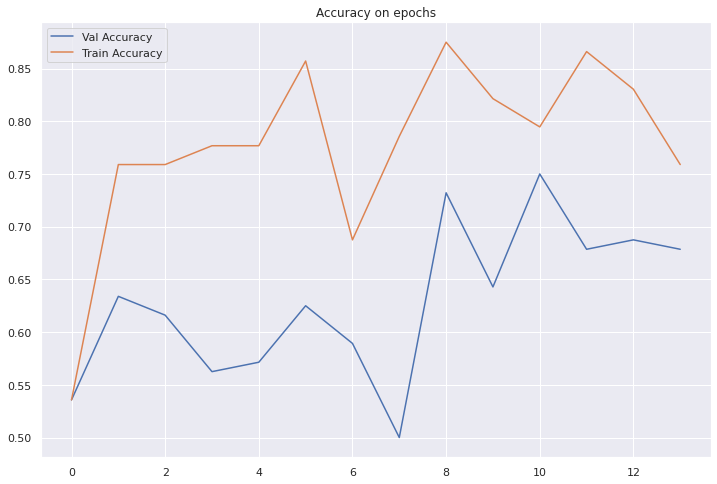

Biggest val Entropy = 21.741024698529923
Smallest val Entropy = 16.657828535352433


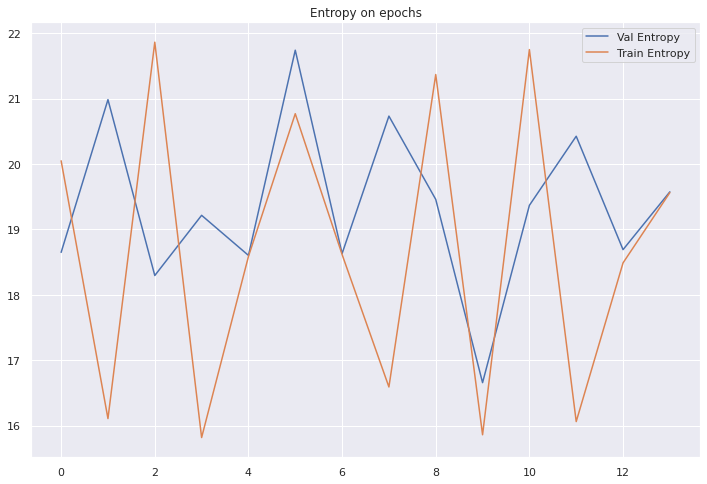

In [ ]:
dropout_model_05.load_state_dict(best_weights)
show_results(history_tr_acc, history_val_acc, metric='Accuracy')
show_results(history_tr_loss, history_val_loss, metric='Entropy')

In [ ]:
evaluate_model(dropout_model_05, test_subset);

Accuracy score =  = 0.568000003695488


Learning curve of accuracy looks the better then the rest of the models but got I little accuracy score on test set. The entropy plot is very cheotic so perhaps different learning rate will make the results more stable.

## 5. Learning rate tuning

Model with lr size = 0.01


Epoch 0:   0%|          | 0/32 [00:00<?, ?batch/s]/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Epoch 0: 100%|██████████| 32/32 [01:06<00:00,  2.06s/batch, cross_entropy=0.571]


Epoch ended, accuracy val score = 0.5267857142857143


Epoch 1: 100%|██████████| 32/32 [00:51<00:00,  1.61s/batch, cross_entropy=1.39]


Epoch ended, accuracy val score = 0.49107142857142855


Epoch 2: 100%|██████████| 32/32 [00:50<00:00,  1.58s/batch, cross_entropy=0.493]


Epoch ended, accuracy val score = 0.5803571428571429


Epoch 3: 100%|██████████| 32/32 [00:53<00:00,  1.69s/batch, cross_entropy=0.577]


Epoch ended, accuracy val score = 0.4732142857142857


Epoch 4: 100%|██████████| 32/32 [00:50<00:00,  1.59s/batch, cross_entropy=-]


Epoch ended, accuracy val score = 0.3482142857142857


Epoch 5: 100%|██████████| 32/32 [00:50<00:00,  1.58s/batch, cross_entropy=0.392]


Epoch ended, accuracy val score = 0.5803571428571429


Epoch 6: 100%|██████████| 32/32 [00:52<00:00,  1.64s/batch, cross_entropy=-]


Epoch ended, accuracy val score = 0.39285714285714285


Epoch 7: 100%|██████████| 32/32 [00:51<00:00,  1.62s/batch, cross_entropy=-]


Epoch ended, accuracy val score = 0.5982142857142857


Epoch 8: 100%|██████████| 32/32 [00:50<00:00,  1.58s/batch, cross_entropy=0.495]


Epoch ended, accuracy val score = 0.5446428571428571


Epoch 9: 100%|██████████| 32/32 [00:50<00:00,  1.59s/batch, cross_entropy=-]


Epoch ended, accuracy val score = 0.4642857142857143


Epoch 10: 100%|██████████| 32/32 [00:53<00:00,  1.66s/batch, cross_entropy=0.67]


Epoch ended, accuracy val score = 0.6071428571428571


Epoch 11: 100%|██████████| 32/32 [00:50<00:00,  1.57s/batch, cross_entropy=0.722]


Epoch ended, accuracy val score = 0.5267857142857143


Epoch 12: 100%|██████████| 32/32 [00:49<00:00,  1.55s/batch, cross_entropy=0.544]


Epoch ended, accuracy val score = 0.625


Epoch 13: 100%|██████████| 32/32 [00:49<00:00,  1.55s/batch, cross_entropy=0.498]


Epoch ended, accuracy val score = 0.6160714285714286


Epoch 14: 100%|██████████| 32/32 [00:51<00:00,  1.62s/batch, cross_entropy=0.619]


Epoch ended, accuracy val score = 0.4732142857142857


Epoch 15: 100%|██████████| 32/32 [00:50<00:00,  1.59s/batch, cross_entropy=0.489]


Epoch ended, accuracy val score = 0.5803571428571429


Epoch 16: 100%|██████████| 32/32 [00:51<00:00,  1.62s/batch, cross_entropy=0.625]


Epoch ended, accuracy val score = 0.5982142857142857

Early stop: error increasing
Biggest val Accuracy = 0.625
Smallest val Accuracy = 0.3482142857142857


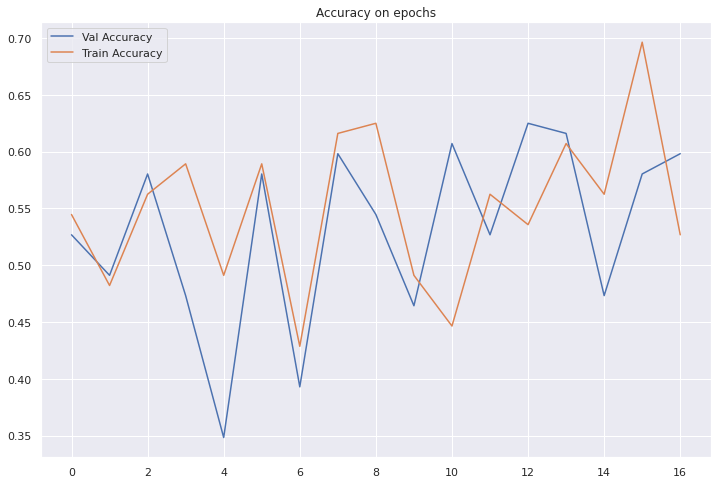

Biggest val Entropy = 24.755259377615793
Smallest val Entropy = 16.39125861440386


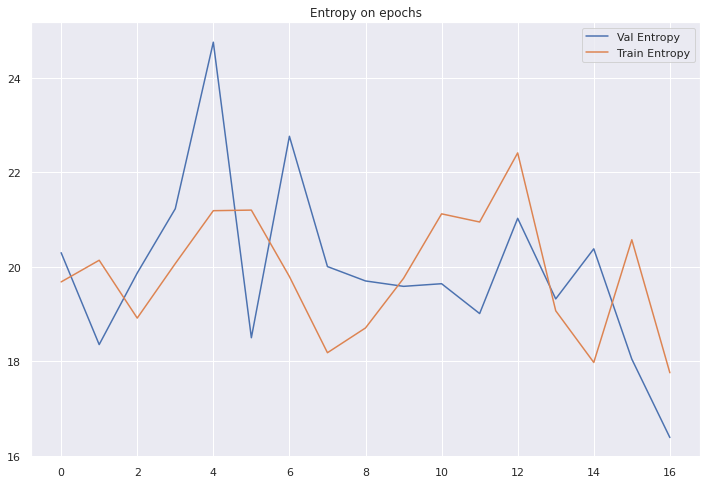

Accuracy score =  = 0.5399999976158142
Accuracy score =  = 0.5120000034570694
Model with lr size = 0.005


Epoch 0:   0%|          | 0/32 [00:00<?, ?batch/s]/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Epoch 0: 100%|██████████| 32/32 [00:50<00:00,  1.58s/batch, cross_entropy=0.435]


Epoch ended, accuracy val score = 0.6607142857142857


Epoch 1: 100%|██████████| 32/32 [00:51<00:00,  1.61s/batch, cross_entropy=1.6]


Epoch ended, accuracy val score = 0.5089285714285714


Epoch 2: 100%|██████████| 32/32 [00:52<00:00,  1.65s/batch, cross_entropy=-]


Epoch ended, accuracy val score = 0.625


Epoch 3: 100%|██████████| 32/32 [00:49<00:00,  1.55s/batch, cross_entropy=1.6]


Epoch ended, accuracy val score = 0.6071428571428571


Epoch 4: 100%|██████████| 32/32 [00:50<00:00,  1.56s/batch, cross_entropy=-]


Epoch ended, accuracy val score = 0.44642857142857145


Epoch 5: 100%|██████████| 32/32 [00:51<00:00,  1.61s/batch, cross_entropy=0.64]


Epoch ended, accuracy val score = 0.5178571428571429


Epoch 6: 100%|██████████| 32/32 [00:51<00:00,  1.62s/batch, cross_entropy=0.345]


Epoch ended, accuracy val score = 0.5714285714285714


Epoch 7: 100%|██████████| 32/32 [00:49<00:00,  1.56s/batch, cross_entropy=0.735]


Epoch ended, accuracy val score = 0.45535714285714285


Epoch 8: 100%|██████████| 32/32 [00:50<00:00,  1.59s/batch, cross_entropy=1.5]


Epoch ended, accuracy val score = 0.5982142857142857


Epoch 9: 100%|██████████| 32/32 [00:52<00:00,  1.65s/batch, cross_entropy=0.512]


Epoch ended, accuracy val score = 0.45535714285714285


Epoch 10: 100%|██████████| 32/32 [00:50<00:00,  1.57s/batch, cross_entropy=1.4]


Epoch ended, accuracy val score = 0.5714285714285714


Epoch 11: 100%|██████████| 32/32 [00:50<00:00,  1.57s/batch, cross_entropy=1.54]


Epoch ended, accuracy val score = 0.4642857142857143


Epoch 12: 100%|██████████| 32/32 [00:53<00:00,  1.66s/batch, cross_entropy=-]


Epoch ended, accuracy val score = 0.6339285714285714


Epoch 13: 100%|██████████| 32/32 [00:51<00:00,  1.60s/batch, cross_entropy=1.22]


Epoch ended, accuracy val score = 0.7053571428571429


Epoch 14: 100%|██████████| 32/32 [00:50<00:00,  1.57s/batch, cross_entropy=0.606]


Epoch ended, accuracy val score = 0.5625


Epoch 15: 100%|██████████| 32/32 [00:52<00:00,  1.63s/batch, cross_entropy=1.61]


Epoch ended, accuracy val score = 0.5625


Epoch 16: 100%|██████████| 32/32 [00:51<00:00,  1.61s/batch, cross_entropy=0.376]


Epoch ended, accuracy val score = 0.5892857142857143


Epoch 17: 100%|██████████| 32/32 [00:50<00:00,  1.58s/batch, cross_entropy=0.422]


Epoch ended, accuracy val score = 0.5714285714285714

Early stop: error increasing
Biggest val Accuracy = 0.7053571428571429
Smallest val Accuracy = 0.44642857142857145


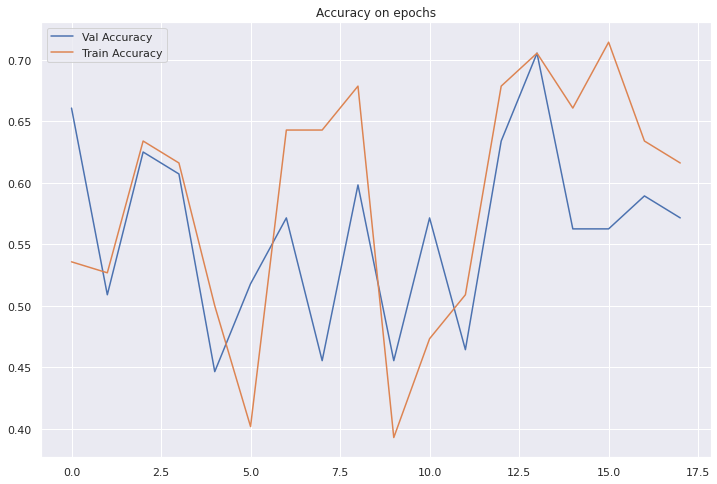

Biggest val Entropy = 22.299683025905065
Smallest val Entropy = 17.57873817852565


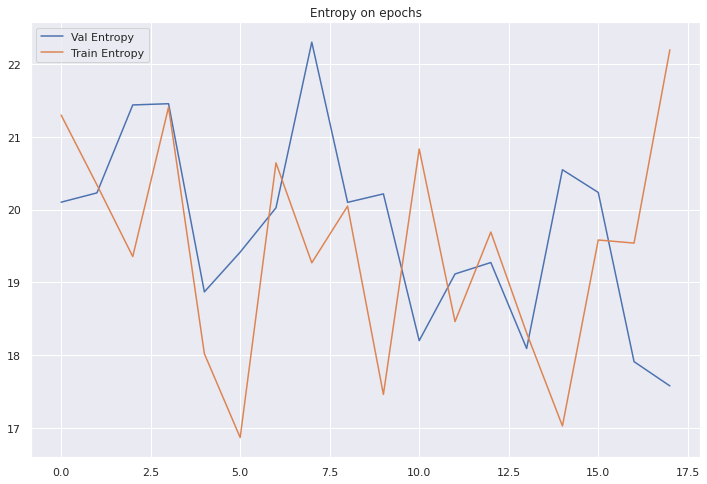

Accuracy score =  = 0.5279999941587448
Accuracy score =  = 0.5159999966621399
Model with lr size = 0.001


Epoch 0:   0%|          | 0/32 [00:00<?, ?batch/s]/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Epoch 0: 100%|██████████| 32/32 [00:52<00:00,  1.64s/batch, cross_entropy=0.573]


Epoch ended, accuracy val score = 0.49107142857142855


Epoch 1: 100%|██████████| 32/32 [00:46<00:00,  1.46s/batch, cross_entropy=-]


Epoch ended, accuracy val score = 0.5357142857142857


Epoch 2: 100%|██████████| 32/32 [00:50<00:00,  1.57s/batch, cross_entropy=-]


Epoch ended, accuracy val score = 0.5446428571428571


Epoch 3: 100%|██████████| 32/32 [00:51<00:00,  1.61s/batch, cross_entropy=0.504]


Epoch ended, accuracy val score = 0.6607142857142857


Epoch 4: 100%|██████████| 32/32 [00:49<00:00,  1.56s/batch, cross_entropy=0.33]


Epoch ended, accuracy val score = 0.6785714285714286


Epoch 5: 100%|██████████| 32/32 [00:51<00:00,  1.60s/batch, cross_entropy=0.995]


Epoch ended, accuracy val score = 0.6339285714285714


Epoch 6: 100%|██████████| 32/32 [00:51<00:00,  1.60s/batch, cross_entropy=0.32]


Epoch ended, accuracy val score = 0.5982142857142857


Epoch 7: 100%|██████████| 32/32 [00:50<00:00,  1.59s/batch, cross_entropy=0.984]


Epoch ended, accuracy val score = 0.6071428571428571


Epoch 8: 100%|██████████| 32/32 [00:51<00:00,  1.61s/batch, cross_entropy=0.348]


Epoch ended, accuracy val score = 0.7053571428571429


Epoch 9: 100%|██████████| 32/32 [00:51<00:00,  1.61s/batch, cross_entropy=0.326]


Epoch ended, accuracy val score = 0.5714285714285714


Epoch 10: 100%|██████████| 32/32 [00:51<00:00,  1.62s/batch, cross_entropy=1.39]


Epoch ended, accuracy val score = 0.5892857142857143


Epoch 11: 100%|██████████| 32/32 [00:50<00:00,  1.56s/batch, cross_entropy=-]


Epoch ended, accuracy val score = 0.5714285714285714


Epoch 12: 100%|██████████| 32/32 [00:51<00:00,  1.61s/batch, cross_entropy=1.41]


Epoch ended, accuracy val score = 0.6517857142857143


Epoch 13: 100%|██████████| 32/32 [00:53<00:00,  1.66s/batch, cross_entropy=-]


Epoch ended, accuracy val score = 0.5803571428571429


Epoch 14: 100%|██████████| 32/32 [00:50<00:00,  1.57s/batch, cross_entropy=0.368]


Epoch ended, accuracy val score = 0.5446428571428571


Epoch 15: 100%|██████████| 32/32 [00:50<00:00,  1.57s/batch, cross_entropy=1.62]


Epoch ended, accuracy val score = 0.7053571428571429


Epoch 16: 100%|██████████| 32/32 [00:53<00:00,  1.66s/batch, cross_entropy=1.48]


Epoch ended, accuracy val score = 0.5982142857142857


Epoch 17: 100%|██████████| 32/32 [00:51<00:00,  1.60s/batch, cross_entropy=0.343]


Epoch ended, accuracy val score = 0.6428571428571429


Epoch 18: 100%|██████████| 32/32 [00:50<00:00,  1.57s/batch, cross_entropy=1.4]


Epoch ended, accuracy val score = 0.6428571428571429


Epoch 19: 100%|██████████| 32/32 [00:52<00:00,  1.65s/batch, cross_entropy=0.448]


Epoch ended, accuracy val score = 0.6428571428571429

Early stop: plato found
Biggest val Accuracy = 0.7053571428571429
Smallest val Accuracy = 0.49107142857142855


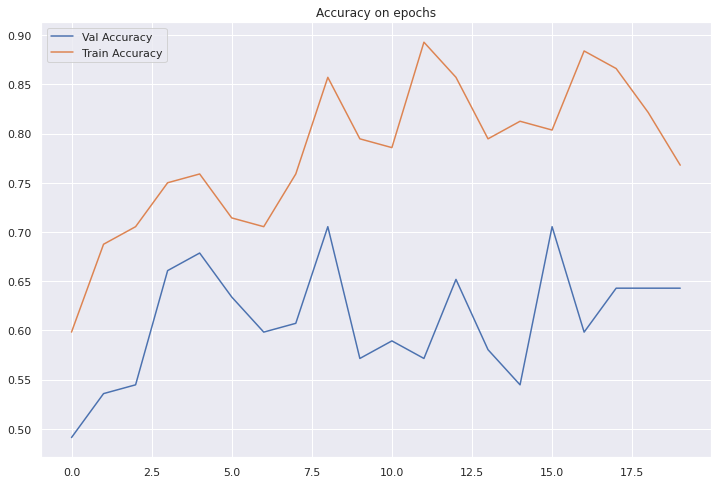

Biggest val Entropy = 21.852656262261526
Smallest val Entropy = 15.882162877491542


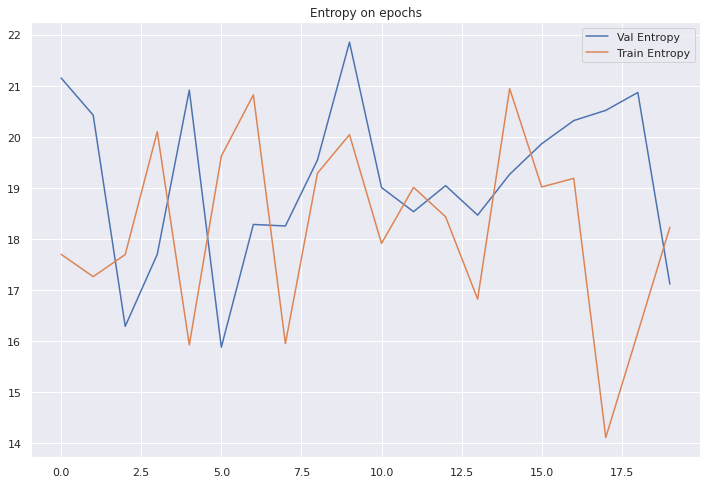

Accuracy score =  = 0.6720000088214875
Accuracy score =  = 0.6080000013113022
Model with lr size = 0.0005


Epoch 0:   0%|          | 0/32 [00:00<?, ?batch/s]/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Epoch 0: 100%|██████████| 32/32 [00:59<00:00,  1.85s/batch, cross_entropy=0.965]


Epoch ended, accuracy val score = 0.4375


Epoch 1: 100%|██████████| 32/32 [00:59<00:00,  1.86s/batch, cross_entropy=0.595]


Epoch ended, accuracy val score = 0.6160714285714286


Epoch 2: 100%|██████████| 32/32 [01:01<00:00,  1.91s/batch, cross_entropy=0.923]


Epoch ended, accuracy val score = 0.5892857142857143


Epoch 3: 100%|██████████| 32/32 [01:05<00:00,  2.06s/batch, cross_entropy=1.12]


Epoch ended, accuracy val score = 0.6696428571428571


Epoch 4: 100%|██████████| 32/32 [01:02<00:00,  1.95s/batch, cross_entropy=0.439]


Epoch ended, accuracy val score = 0.6964285714285714


Epoch 5: 100%|██████████| 32/32 [01:00<00:00,  1.88s/batch, cross_entropy=0.373]


Epoch ended, accuracy val score = 0.5892857142857143


Epoch 6: 100%|██████████| 32/32 [01:02<00:00,  1.95s/batch, cross_entropy=0.782]


Epoch ended, accuracy val score = 0.6875


Epoch 7: 100%|██████████| 32/32 [00:59<00:00,  1.86s/batch, cross_entropy=-]


Epoch ended, accuracy val score = 0.6339285714285714


Epoch 8: 100%|██████████| 32/32 [00:58<00:00,  1.83s/batch, cross_entropy=0.322]


Epoch ended, accuracy val score = 0.6517857142857143


Epoch 9: 100%|██████████| 32/32 [01:01<00:00,  1.91s/batch, cross_entropy=0.336]


Epoch ended, accuracy val score = 0.7232142857142857


Epoch 10: 100%|██████████| 32/32 [01:02<00:00,  1.95s/batch, cross_entropy=-]


Epoch ended, accuracy val score = 0.7142857142857143


Epoch 11: 100%|██████████| 32/32 [00:58<00:00,  1.83s/batch, cross_entropy=0.871]


Epoch ended, accuracy val score = 0.5892857142857143


Epoch 12: 100%|██████████| 32/32 [00:59<00:00,  1.87s/batch, cross_entropy=-]


Epoch ended, accuracy val score = 0.7142857142857143


Epoch 13: 100%|██████████| 32/32 [00:58<00:00,  1.84s/batch, cross_entropy=1.55]


Epoch ended, accuracy val score = 0.75


Epoch 14: 100%|██████████| 32/32 [01:00<00:00,  1.88s/batch, cross_entropy=1.43]


Epoch ended, accuracy val score = 0.5625


Epoch 15: 100%|██████████| 32/32 [00:58<00:00,  1.84s/batch, cross_entropy=-]


Epoch ended, accuracy val score = 0.6785714285714286


Epoch 16: 100%|██████████| 32/32 [00:58<00:00,  1.84s/batch, cross_entropy=0.805]


Epoch ended, accuracy val score = 0.6607142857142857


Epoch 17: 100%|██████████| 32/32 [00:59<00:00,  1.87s/batch, cross_entropy=-]


Epoch ended, accuracy val score = 0.5982142857142857

Early stop: error increasing
Biggest val Accuracy = 0.75
Smallest val Accuracy = 0.4375


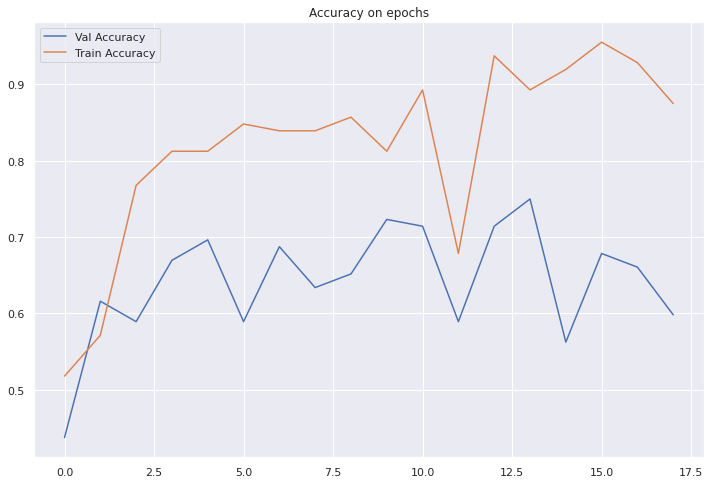

Biggest val Entropy = 23.540148632866995
Smallest val Entropy = 15.784310783658709


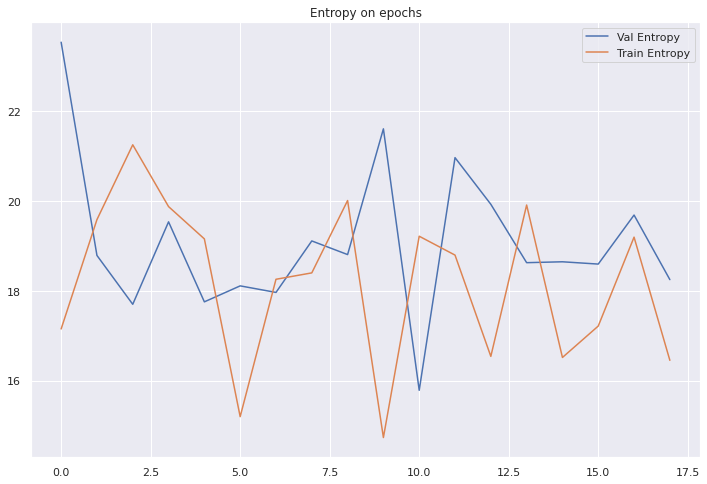

Accuracy score =  = 0.69200000166893
Accuracy score =  = 0.6440000057220459
Model with lr size = 0.0001


Epoch 0:   0%|          | 0/32 [00:00<?, ?batch/s]/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Epoch 0: 100%|██████████| 32/32 [00:58<00:00,  1.84s/batch, cross_entropy=0.763]


Epoch ended, accuracy val score = 0.5178571428571429


Epoch 1: 100%|██████████| 32/32 [01:00<00:00,  1.89s/batch, cross_entropy=1.39]


Epoch ended, accuracy val score = 0.6160714285714286


Epoch 2: 100%|██████████| 32/32 [01:00<00:00,  1.89s/batch, cross_entropy=-]


Epoch ended, accuracy val score = 0.6517857142857143


Epoch 3: 100%|██████████| 32/32 [01:00<00:00,  1.90s/batch, cross_entropy=-]


Epoch ended, accuracy val score = 0.5803571428571429


Epoch 4: 100%|██████████| 32/32 [01:01<00:00,  1.93s/batch, cross_entropy=0.562]


Epoch ended, accuracy val score = 0.5178571428571429


Epoch 5: 100%|██████████| 32/32 [00:59<00:00,  1.87s/batch, cross_entropy=0.672]


Epoch ended, accuracy val score = 0.5982142857142857


Epoch 6: 100%|██████████| 32/32 [01:00<00:00,  1.91s/batch, cross_entropy=0.472]


Epoch ended, accuracy val score = 0.6517857142857143


Epoch 7: 100%|██████████| 32/32 [00:59<00:00,  1.87s/batch, cross_entropy=0.504]


Epoch ended, accuracy val score = 0.6964285714285714


Epoch 8: 100%|██████████| 32/32 [01:00<00:00,  1.88s/batch, cross_entropy=-]


Epoch ended, accuracy val score = 0.7232142857142857


Epoch 9: 100%|██████████| 32/32 [00:55<00:00,  1.74s/batch, cross_entropy=1.44]


Epoch ended, accuracy val score = 0.7232142857142857


Epoch 10: 100%|██████████| 32/32 [00:59<00:00,  1.86s/batch, cross_entropy=1.43]


Epoch ended, accuracy val score = 0.6964285714285714


Epoch 11: 100%|██████████| 32/32 [00:59<00:00,  1.85s/batch, cross_entropy=0.372]


Epoch ended, accuracy val score = 0.6696428571428571


Epoch 12: 100%|██████████| 32/32 [00:58<00:00,  1.84s/batch, cross_entropy=0.456]


Epoch ended, accuracy val score = 0.6964285714285714


Epoch 13: 100%|██████████| 32/32 [00:59<00:00,  1.87s/batch, cross_entropy=-]


Epoch ended, accuracy val score = 0.6964285714285714


Epoch 14: 100%|██████████| 32/32 [01:01<00:00,  1.93s/batch, cross_entropy=0.402]


Epoch ended, accuracy val score = 0.6339285714285714


Epoch 15: 100%|██████████| 32/32 [00:59<00:00,  1.86s/batch, cross_entropy=-]


Epoch ended, accuracy val score = 0.625


Epoch 16: 100%|██████████| 32/32 [00:58<00:00,  1.82s/batch, cross_entropy=-]


Epoch ended, accuracy val score = 0.7053571428571429

Early stop: error increasing
Biggest val Accuracy = 0.7232142857142857
Smallest val Accuracy = 0.5178571428571429


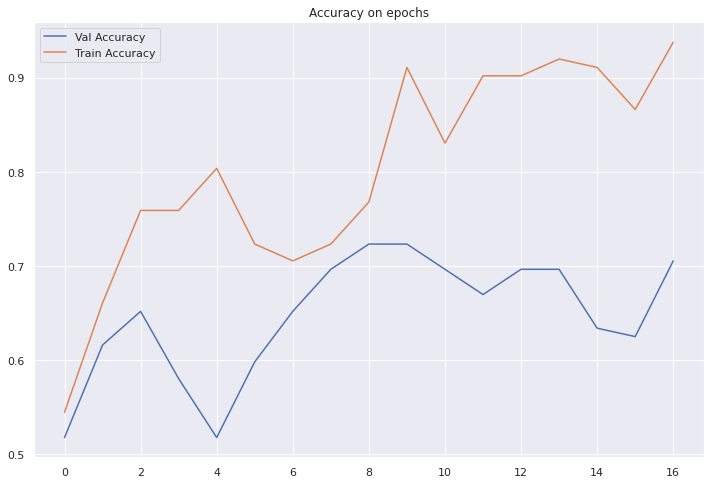

Biggest val Entropy = 20.931647334780013
Smallest val Entropy = 18.513073308127268


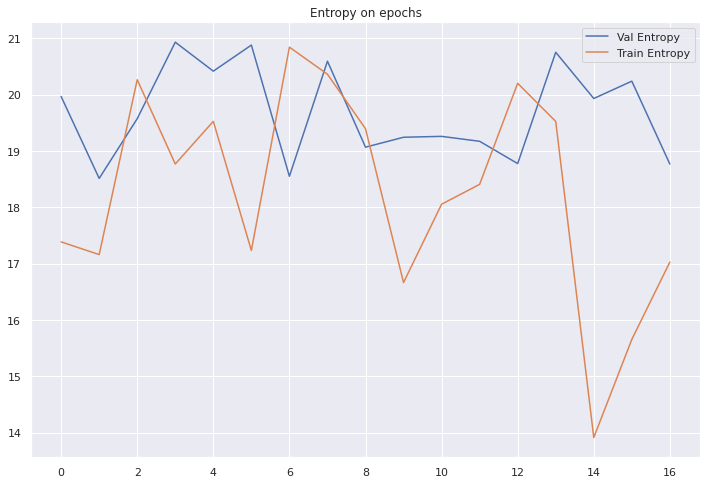

Accuracy score =  = 0.5760000020265579
Accuracy score =  = 0.5399999916553497


In [ ]:
results = pd.DataFrame(columns=['val_acc', 'test_acc'])
for learning_rate in (0.01, 0.005, 0.001, 0.0005, 0.0001):
  print(f'Model with lr size = {learning_rate}')
  cv_model = PlusCVRegDrop(learning_rate=learning_rate, weight_decay=0.001, p1=0.5)

  history_val_loss, history_tr_loss, history_val_acc, history_tr_acc, best_weights = train_cv(cv_model, 50, 16, check_early_stop=True)
  cv_model.load_state_dict(best_weights)

  show_results(history_tr_acc, history_val_acc, metric='Accuracy')
  show_results(history_tr_loss, history_val_loss, metric='Entropy')
  res = pd.DataFrame({
        'val_acc': [evaluate_model(cv_model, val_subset)],
        'test_acc': [evaluate_model(cv_model, test_subset)]
    })
  results = pd.concat([results, res], axis=0)

The best model seems to be one wirh learning_rate=0.0005. It's validation score = 0.692 and test score = 0.644. Next I'm going ti try pretrained models.

In [ ]:
results

,val_acc,test_acc
0.0100,0.539,0.512
0.0050,0.527,0.515
0.0010,0.672,0.608
0.0005,0.692,0.644
0.0001,0.576,0.539


The accuracy score on 0.0005 learning rate is the best on both train and test datasets so I think it is optimal for my architecture. I fear I won't get much better models as the dataset is not that big and so I'll try to use pretrained models to achieve better results.

## 6. Pretrained models.

### Specific functions

In [ ]:
def pretrained_cv(model, n_epochs=5, batch_size=32, learning_rate=0.001, disable_bar=False):
  # Hold the best model
  best_acc = 0   # init to infinity
  best_weights = None
  train_dataloader = DataLoader(train, batch_size=batch_size, shuffle=True)

  for epoch in range(n_epochs):
      model.train()

      loop = tqdm.tqdm(train_dataloader, unit="batch", mininterval=0, disable=disable_bar)
      loop.set_description(f"Epoch {epoch}")

      for X_batch, y_batch in loop :
          y_pred = model(X_batch)
          y_pred = y_pred.squeeze()

          y_batch = y_batch.float()
          loss = loss_fn(y_pred, y_batch)
          # backward pass
          optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
          optimizer.zero_grad()
          loss.backward()
          # update weights
          optimizer.step()
          # print progress
          loop.set_postfix(cross_entropy=loss.item())
  val_acc = test_unfreezed(model, val_subset)
  if best_acc < val_acc:
    best_acc = val_acc
    best_weights = copy.deepcopy(model.state_dict())
  return best_weights

In [ ]:
resnet = models.resnet50(pretrained=True)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


As resnet already has hot dog class, I can just see if hot dog class probability is the highets or not and give prediction based on that. Hot dog class is 934, so I'll just hardcode a function.

In [ ]:
def eval_pretrained(model, data, hotdog_idx=934):
  data = torch.utils.data.DataLoader(data, batch_size=25, shuffle=True)
  n_iter = 0
  accuracy_score = 0
  for X, y in data:
    #y = y.float()
    n_iter += 1
    pred = model(X)
    hotdog_probs = pred[:, hotdog_idx]
    other_probs = torch.cat((pred[:, :hotdog_idx], pred[:, hotdog_idx+1:]), dim=1)
    # Compare probability for hotdog class with maximum probability for all other classes
    max_other_probs, _ = torch.max(other_probs, dim=1)
    not_hotdog = hotdog_probs < max_other_probs
    acc = accuracy(not_hotdog, y).item()
    print(f'Accuracy of batch {n_iter} = {acc}')
    accuracy_score += acc

  accuracy_score = accuracy_score/n_iter
  print(f'Pretrained model has acc_score = {accuracy_score}')
  return accuracy_score

In [ ]:
def test_unfreezed(model, dataset, batch_size=50):
  model.eval()
  val_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
  num_batches = 0
  accuracy_score = 0
  for X, y in val_dataloader:
    y = y.float()
    pred = model(X).squeeze()
    accuracy_score += accuracy(pred, y).item()
    num_batches += 1
  accuracy_score = accuracy_score / num_batches
  print(f'Accuracy score =  = {accuracy_score}')
  return accuracy_score

### Resnet

In [ ]:
resnet.eval()
res = eval_pretrained(resnet, test_subset)

Accuracy of batch 1 = 0.6800000071525574
Accuracy of batch 2 = 0.7599999904632568
Accuracy of batch 3 = 0.800000011920929
Accuracy of batch 4 = 0.7200000286102295
Accuracy of batch 5 = 0.800000011920929
Accuracy of batch 6 = 0.7599999904632568
Accuracy of batch 7 = 0.800000011920929
Accuracy of batch 8 = 0.6800000071525574
Accuracy of batch 9 = 0.8799999952316284
Accuracy of batch 10 = 0.7599999904632568
Pretrained model has acc_score = 0.764000004529953


From the very beggining I see that pretrained model gave better results then my own. 0.76 vs 0.64. I'll try to unfreeze last layer to train model strictly for binary case.

In order to use unfreeze method I'll disable grad reqirement to all the layers apart from last one which will result in only one neuron (as the classification is binary)

In [ ]:
for param in resnet.parameters():
  param.requires_grad = False

In [ ]:
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 1)
resnet.fc.requires_grad = True
resnet.sigmoid = nn.Sigmoid()

In [ ]:
best_weights = pretrained_cv(resnet, 5, 32)

Epoch 4: 100%|██████████| 16/16 [02:22<00:00,  8.90s/batch, cross_entropy=19.8]


In [ ]:
resnet.load_state_dict(best_weights)
val_acc = test_unfreezed(resnet, val_subset)
test_acc = test_unfreezed(resnet, test_subset)

Accuracy score =  = 0.8439999938011169
Accuracy score =  = 0.8320000052452088


In [ ]:
print(f'Resnet freezed validation accuracy = {val_acc}')
print(f'Resnet freezed test accuracy = {test_acc}')

Resnet freezed validation accuracy = 0.8439999938011169
Resnet freezed test accuracy = 0.8320000052452088


After training the result got even higher - 0.832 on test set.

Next I'll try another pretrained model - densenet.

### Densenet

In [ ]:
densenet = models.densenet121(pretrained=True)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
densenet.eval()
res = eval_pretrained(densenet, test_subset)

Accuracy of batch 1 = 0.800000011920929
Accuracy of batch 2 = 0.9599999785423279
Accuracy of batch 3 = 0.800000011920929
Accuracy of batch 4 = 0.7599999904632568
Accuracy of batch 5 = 0.7599999904632568
Accuracy of batch 6 = 0.7599999904632568
Accuracy of batch 7 = 0.800000011920929
Accuracy of batch 8 = 0.7599999904632568
Accuracy of batch 9 = 0.9200000166893005
Accuracy of batch 10 = 0.9200000166893005
Pretrained model has acc_score = 0.8240000009536743


Densenet has better result without training - 0.82 vs 0.76 in case of resnet. Next I'll try to retrain last layer.

In [ ]:
for param in densenet.parameters():
  param.requires_grad = False

In [ ]:
num_ftrs = densenet.classifier.in_features
densenet.classifier = nn.Linear(num_ftrs, 1)
densenet.classifier.requires_grad = True
densenet.sigmoid = nn.Sigmoid()

In [ ]:
best_weights_dense = pretrained_cv(densenet, 10)

Epoch 9: 100%|██████████| 16/16 [02:01<00:00,  7.56s/batch, cross_entropy=22.1]


Accuracy score =  = 0.8320000052452088


In [ ]:
densenet.load_state_dict(best_weights_dense)
val_acc = test_unfreezed(densenet, val_subset)
test_acc = test_unfreezed(densenet, test_subset)

Accuracy score =  = 0.8319999933242798
Accuracy score =  = 0.8559999942779541


In [ ]:
print(f'Resnet freezed validation accuracy = {val_acc}')
print(f'Resnet freezed test accuracy = {test_acc}')

Resnet freezed validation accuracy = 0.8319999933242798
Resnet freezed test accuracy = 0.8559999942779541


Achieved results are very simmilar to those I achived with manipulations with target and no training. In that case the result was 0.824, with training it is 0.855.

Achieved results are very simmilar to those I got with resnet. Both networks trained about the same amount of time. Test accuracy of resnet = 0.832, densenet = 0.855. Interestingly, in case of no training and just picking 947th class (hotdog) resnet got much worse results - 0.76, compared to densenet - 0.82.

## 7. Conclusions

I've preformed 3 types of task using deep learning methods: regression, classification and computer vision. On tablar data tasks the achieved results were better then common linear or logistic regression but in both cases were worse that gradient boosting. In case of CV, achieved results appeared relatively good, although significantly worse than in case of using pretrained models. Those, combined with trained by myself final layer gave the best results. I think that the main limitation in this part was the dataset - I  coudn't achieve stable results and so my models tended to overfit. Perhaps with bigger dataset resulting accuracy woud have been higher.